In [1]:
import sys
sys.path.append('../')
import src.utils as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
reload(utils)
import scipy.stats as stat

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings("ignore")

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')

In [3]:
params = {
    'r' : 0.01,
    'p' : 0.5 ,
    'u' : 1.02,
    'd' : 0.99,
    'T' : 1,
    'S0' : 100,
    'Nt': 10,
}

BT = utils.binomial_tree(**params)

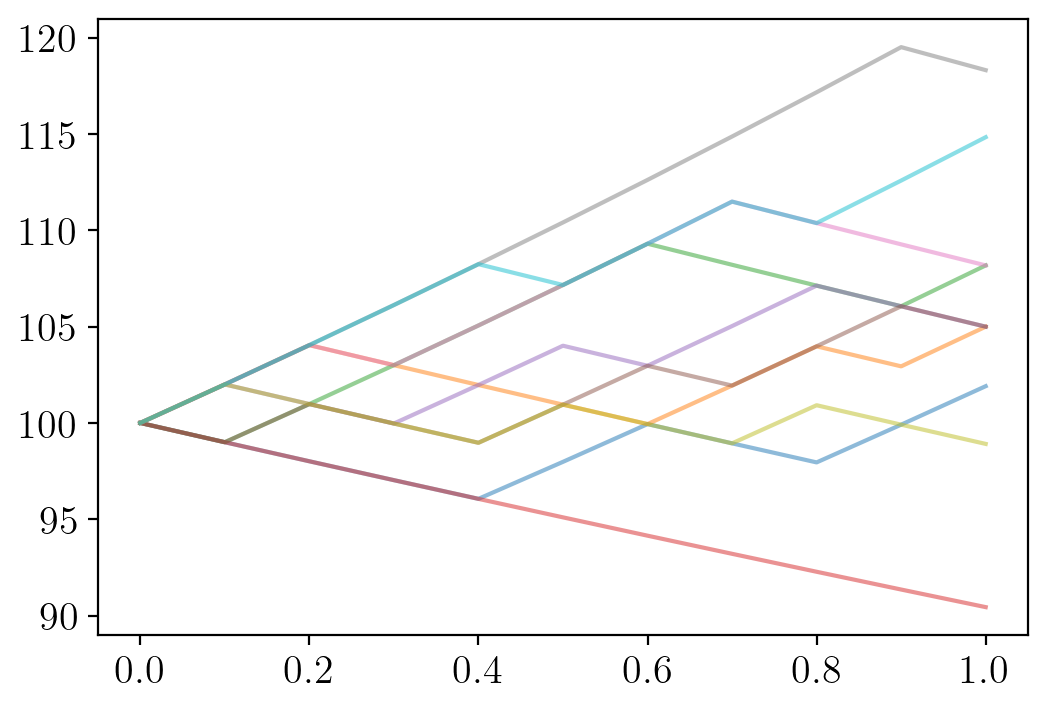

In [4]:
plt.plot(BT.timesteps, BT.simulate(nsims = 10), alpha = 0.5)
plt.show()

In [5]:
sigma = 0.2
Nt = 1000
T = 1.
mu = 0.03
r = 0.01
u = 1. + sigma * np.sqrt(T/Nt)
d = 1./u
p = 0.5 + (mu / (2.*sigma) - sigma/4)* np.sqrt(T/Nt)

params = {
    'r' : r,
    'p' : p,
    'u' : u,
    'd' : d,
    'T' : T,
    'S0' : 100,
    'Nt': Nt,
}

BT = utils.binomial_tree(**params)

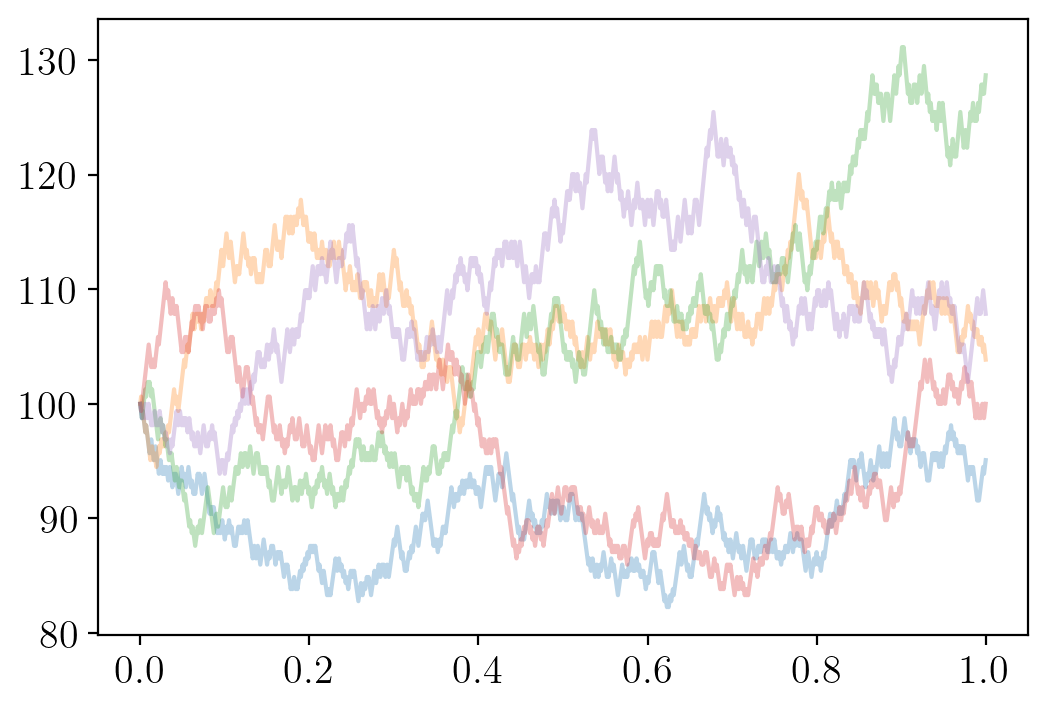

In [6]:
plt.plot(BT.timesteps, BT.simulate(nsims = 5), alpha = 0.3)
plt.show()

In [7]:
GBM = utils.GeometricBrownianMotion(x0 = 100., mu = mu, sigma = sigma, T = T, Nt = Nt)

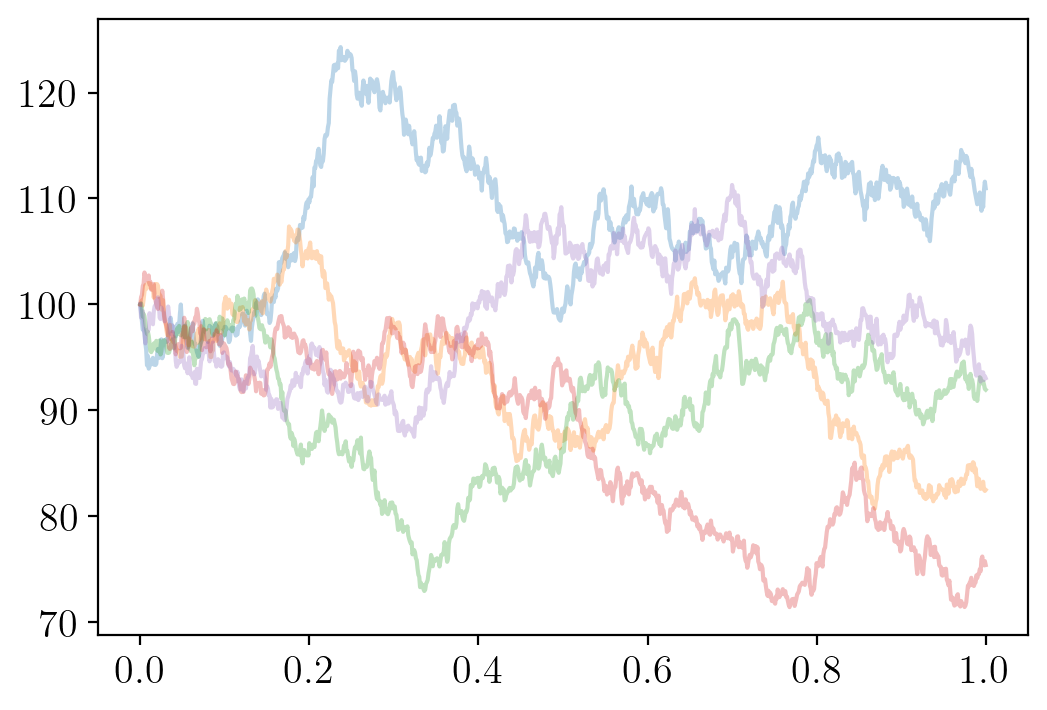

In [8]:
plt.plot(GBM.timesteps, GBM.simulate(nsims = 5), alpha = 0.3)
plt.show()

# Pricing with the binomial tree

In [9]:
default_params = {
'K' : 100,
't' : 0,
'T' : 1,
'r' : 0.03,
'S' : 100,
'sigma' : 0.1
}

K = default_params['K']
S = np.linspace(start = 50,stop = 150, num = 100)
t = default_params['t']
S0 = default_params['S']
T = default_params['T']
r = default_params['r']
mu = 0.1
sigma = default_params['sigma']

In [4]:
from src.utils import put_option_payoff
def put_option_payoff_fixed_K(x):
    return put_option_payoff(K, x)

In [10]:
Nt = 1_000
u = 1. + sigma * np.sqrt(T/Nt)
d = 1./u
p = 0.5 + (mu / (2.*sigma) - sigma/4)* np.sqrt(T/Nt)

params = {
    'r' : r,
    'p' : p,
    'u' : u,
    'd' : d,
    'T' : T,
    'S0' : S0,
    'Nt': Nt,
    'payoff_fct' : put_option_payoff_fixed_K,
    'american' : False
}

BT = utils.binomial_tree(**params)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4739.61it/s]


## Sanity check

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4609.91it/s]


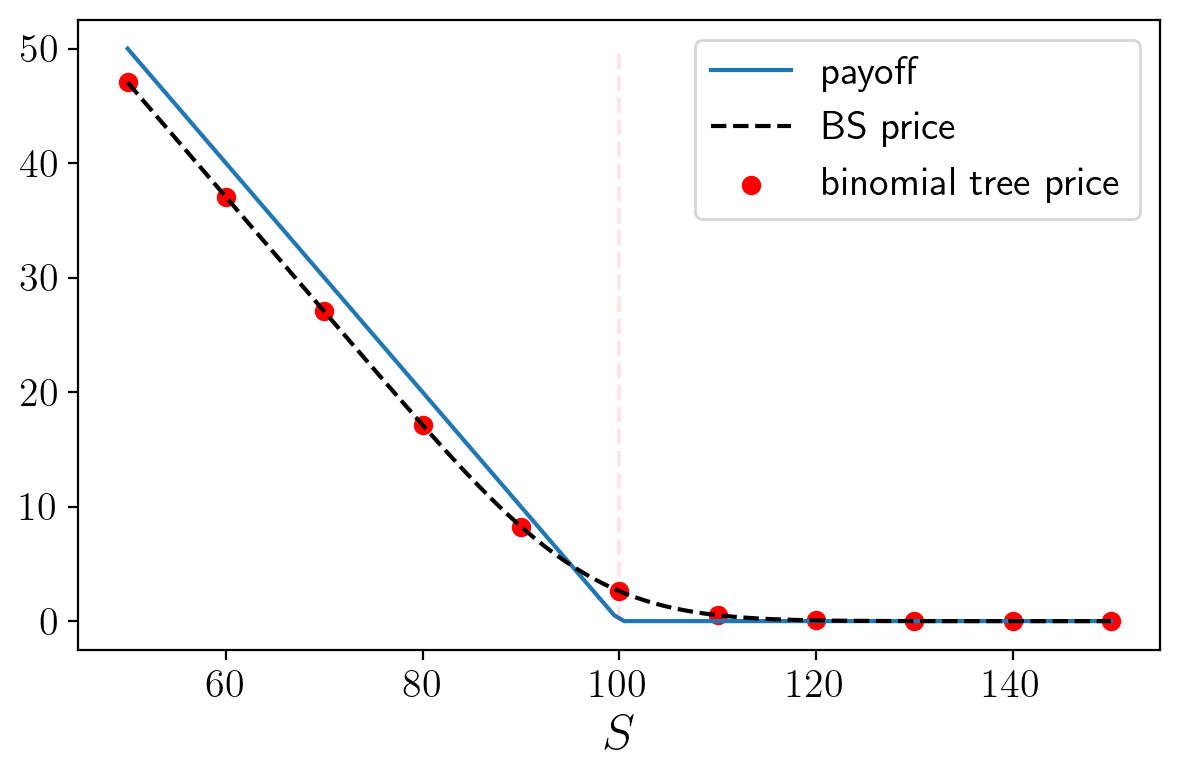

In [11]:
prices = utils.computeBlackScholesPutPrice(t,T,S,r,sigma,K)
payoff = utils.put_option_payoff(K = K, S = S)



plt.figure()
plt.plot(S, payoff, linestyle = '-', label='payoff')
plt.plot(S, prices, linestyle = '--', color='black', label='BS price')
plt.vlines(x = K, ymin = 0, ymax = np.max(payoff), color = 'r', linestyles='--', alpha = 0.1)

S_small = np.linspace(start = 50,stop = 150, num = 11)
price_BT = np.zeros_like(S_small)
for iS,s in enumerate(S_small):
    params_aux = params.copy()
    params_aux['S0'] = s
    BT = utils.binomial_tree(**params_aux)
    price_BT[iS] = BT.derivative_price_at_zero

plt.scatter(S_small, price_BT, marker = 'o', color='red', label= 'binomial tree price')
resolution_value = 50
plt.tight_layout()
plt.legend()
plt.xlabel(r'$S$',  fontsize=18)
plt.tight_layout()
plt.savefig('../figures/put-price-vs-payoff-vs-BT.pdf', format="pdf", dpi=resolution_value)
plt.show()

## Sanity check

In [12]:
def identity_fct(S):
    return S
params_aux = params.copy()
params_aux['payoff_fct'] = identity_fct

BT = utils.binomial_tree(**params_aux)
BT.derivative_price_at_zero

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4683.52it/s]


99.9999999999992

# American put option

In [13]:
params['american'] = False
BT = utils.binomial_tree(**params)
BT.derivative_price_at_zero

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4633.23it/s]


2.6195061463063944

In [14]:
params['american'] = True
Nt = 10_000
u = 1. + sigma * np.sqrt(T/Nt)
d = 1./u
p = 0.5 + (mu / (2.*sigma) - sigma/4)* np.sqrt(T/Nt)

params = {
    'r' : r,
    'p' : p,
    'u' : u,
    'd' : d,
    'T' : T,
    'S0' : S0,
    'Nt': Nt,
    'payoff_fct' : put_option_payoff_fixed_K,
    'american' : True
}

BT = utils.binomial_tree(**params)
BT.derivative_price_at_zero

100%|█████████████████████████████████████| 10000/10000 [06:49<00:00, 24.41it/s]


2.924001850963925

In [15]:
AUX = np.multiply(BT.asset_prices,BT.exercise_early)

In [16]:
boundary = np.max(AUX, axis = 0)
idx = np.where(boundary==0)
boundary[idx] = np.NaN

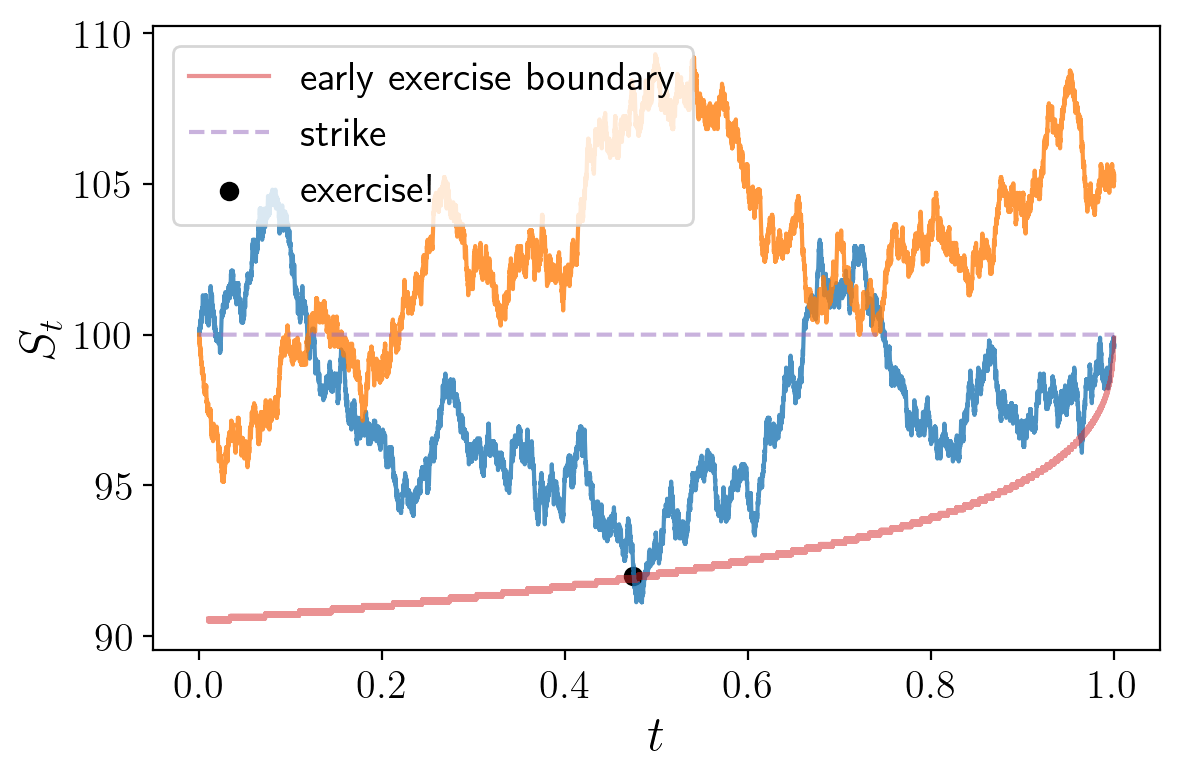

In [61]:
np.random.seed(1234)
plt.plot(BT.timesteps, BT.simulate(nsims = 2), alpha = 0.8)

plt.plot(BT.timesteps, boundary, alpha = 0.5, color='tab:red', label = 'early exercise boundary')
plt.plot(BT.timesteps, np.ones_like(BT.timesteps)*K, linestyle='--', color='tab:purple', alpha = 0.5, label = 'strike')

plt.scatter(0.474, 92, marker = 'o', color = 'black', label= 'exercise!')

resolution_value = 50
plt.tight_layout()
plt.legend()
plt.xlabel(r'$t$',  fontsize=18)
plt.ylabel(r'$S_t$',  fontsize=18)
plt.tight_layout()
plt.savefig('../figures/sample-path-boundary-put-option-BT.pdf', format="pdf", dpi=resolution_value)
plt.show()

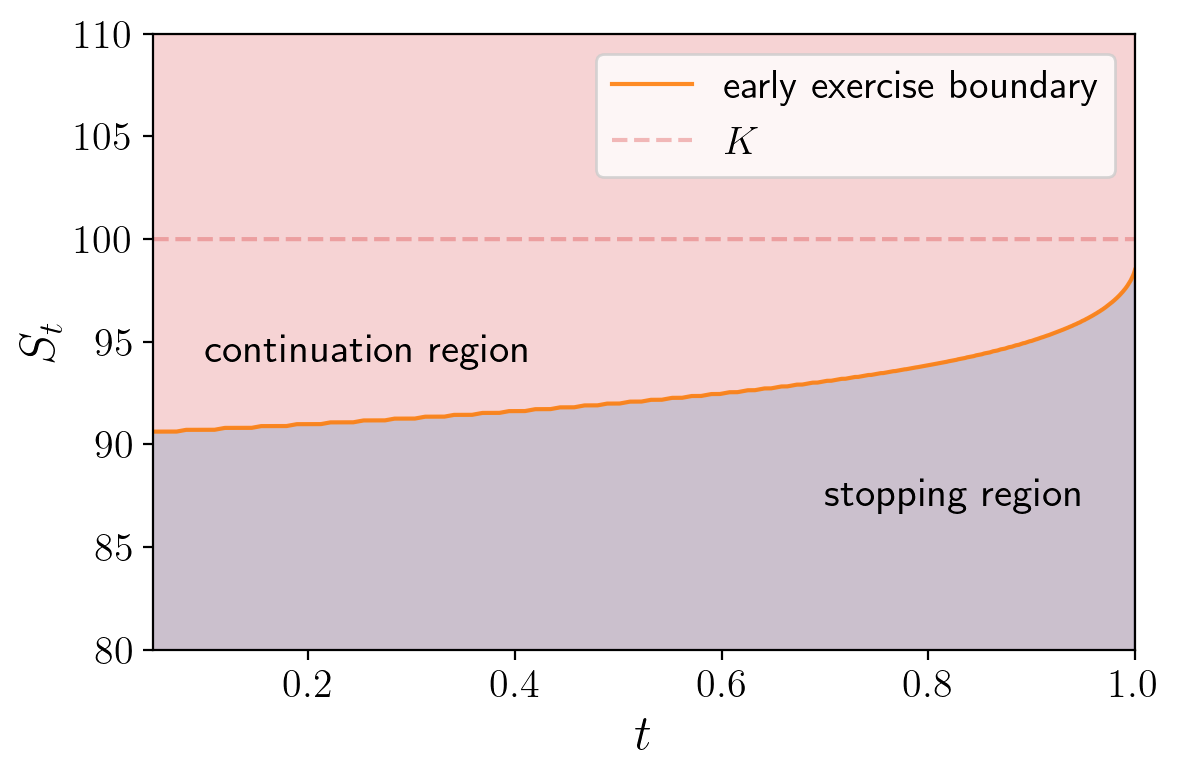

In [34]:
import pandas as pd

smooth_boundary = np.array(pd.DataFrame(boundary).rolling(100).mean()).reshape(-1,)

plt.plot(BT.timesteps, smooth_boundary, alpha = 0.9, color='tab:orange', label = 'early exercise boundary')
plt.plot(BT.timesteps, np.ones_like(BT.timesteps)*K, linestyle='--', color='tab:red', alpha = 0.3, label = r'$K$')
resolution_value = 50

ymax = 110
plt.fill_between(BT.timesteps, np.ones_like(BT.timesteps)*ymax, color = 'tab:red' , alpha=0.2)
plt.fill_between(BT.timesteps, smooth_boundary, color = 'tab:blue' , alpha=0.2)

plt.text(0.1, 94, "continuation region", fontsize=15)
plt.text(0.7, 87, "stopping region", fontsize=15)

plt.legend()
plt.xlabel(r'$t$',  fontsize=18)
plt.ylabel(r'$S_t$',  fontsize=18)
plt.ylim(80,ymax)
plt.xlim(0.05,1.)
plt.tight_layout()
plt.savefig('../figures/boundary-plot-with-regions.pdf', format="pdf", dpi=resolution_value)
plt.show()

# American put versus European put

In [7]:
sigma = 0.5
Nt = 500
S0 = 100
T = 2.
mu = 0.03
r = 0.25
K = 100
u = 1. + sigma * np.sqrt(T/Nt)
d = 1./u
p = 0.5 + (mu / (2.*sigma) - sigma/4)* np.sqrt(T/Nt)

from tqdm import tqdm 

from src.utils import put_option_payoff
def put_option_payoff_fixed_K(x):
    return put_option_payoff(K, x)

params = {
    'r' : r,
    'p' : p,
    'u' : u,
    'd' : d,
    'T' : T,
    'S0' : S0,
    'Nt': Nt,
    'payoff_fct' : put_option_payoff_fixed_K,
    'american' : True,
    'disable_progress_bar' : True
}

In [9]:
Sm = 0.5
SM = 250
num = 50
Num = 100
S = np.linspace(start = Sm,stop = SM, num = Num)

prices = utils.computeBlackScholesPutPrice(0,T,S,r,sigma,K)
payoff = utils.put_option_payoff(K = K, S = S)

S_small = np.linspace(start = Sm,stop = SM, num = num)
price_BT = np.zeros_like(S_small)
for iS,s in tqdm(enumerate(S_small)):
    params_aux = params.copy()
    params_aux['S0'] = s
    BT = utils.binomial_tree(**params_aux)
    price_BT[iS] = BT.derivative_price_at_zero

50it [00:51,  1.03s/it]


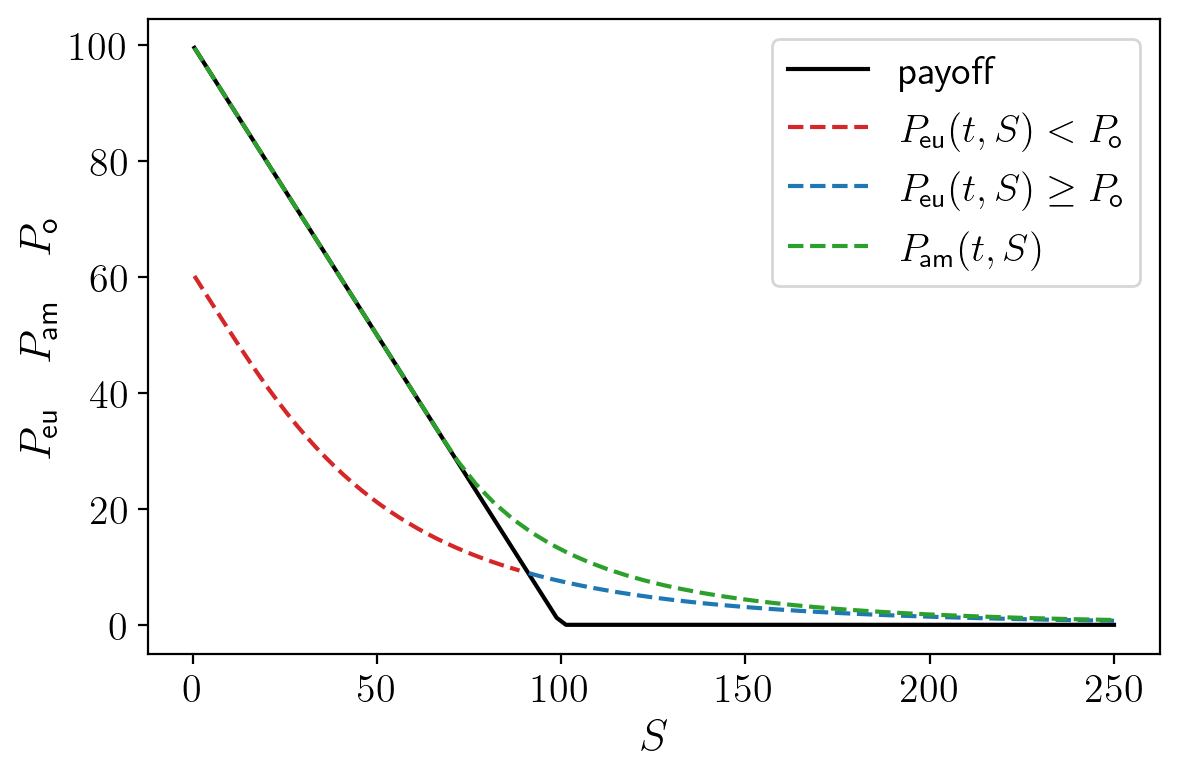

In [29]:
mask_less = np.argwhere(prices< put_option_payoff_fixed_K(S))
mask_more = np.argwhere(prices>= put_option_payoff_fixed_K(S))

plt.figure()
plt.plot(S, payoff, linestyle = '-', color='black', label='payoff')
plt.plot(S[mask_less], prices[mask_less], linestyle = '--', color='tab:red', label=r'$P_{\!\text{eu}}(t,S)<P_{\!\text{o}}$')
plt.plot(S[mask_more], prices[mask_more], linestyle = '--', color='tab:blue', label=r'$P_{\!\text{eu}}(t,S)\geq P_{\!\text{o}}$')

#plt.vlines(x = K, ymin = 0, ymax = np.max(payoff), color = 'r', linestyles='--', alpha = 0.1)
plt.plot(S_small, price_BT, linestyle = '--', color='tab:green', label= r'$P_{\!\text{am}}(t,S)$')
resolution_value = 50
plt.tight_layout()
plt.legend()
plt.xlabel(r'$S$',  fontsize=16)
plt.ylabel(r'$P_{\!\text{eu}}\quad P_{\!\text{am}}\quad P_{\!\text{o}}$',  fontsize=16)
plt.tight_layout()
plt.savefig('../figures/put-american-vs-european.pdf', format="pdf", dpi=resolution_value)
plt.show()